In [ ]:
# === colab configuration ===
# Skip this cell if running demo file locally!

from google.colab import drive
import sys

# setting paths
repository_path = '/content/time-series-forecasting-with-transformers/'
dataset_path = repository_path + 'datasets/spx.csv'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
# drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/francescobaraldi/time-series-forecasting-with-transformers
# ! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from dataset import StockDatasetSW_multistep, StockDatasetSW_singlestep, YahooDatasetSW_singlestep
from model import Transformer, TransformerDecoder, TransformerDecoder_v2, DotProductAttention
from eval_plot import eval_mae, eval_mae_decoder, plot_scores
from utils import scaler

try:
    executing_on_colab
except NameError:
    executing_on_colab = False

## Load datasets

In [2]:
if not executing_on_colab:
    sp500_dataset_path = "datasets/spx.csv"
    yahoo_dataset_path = "datasets/yahoo_stock.csv"
sp500 = pd.read_csv(sp500_dataset_path)
yahoo = pd.read_csv(yahoo_dataset_path)

## Prepare sp500 dataset

In [3]:
sp500_data = sp500['close'].to_numpy()
sp500_data = torch.from_numpy(sp500_data).to(torch.float32)

sp500_trainset = sp500_data[0:int(len(sp500_data) * 0.7)]
sp500_testset = sp500_data[int(len(sp500_data) * 0.7):]

sp500_trainset_scaled, sp500_testset_scaled = scaler(sp500_trainset, sp500_testset)

## Prepare yahoo dataset

In [4]:
yahoo_data = yahoo[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']]
yahoo_class_idx = 3
yahoo_trainset = yahoo_data.iloc[:int(len(yahoo_data) * 0.7)]
yahoo_testset = yahoo_data.iloc[int(len(yahoo_data) * 0.7):]
scaler = MinMaxScaler()
scaler.fit(yahoo_trainset)
yahoo_trainset_scaled = scaler.transform(yahoo_trainset)
yahoo_testset_scaled = scaler.transform(yahoo_testset)

## Transformer std.

In [ ]:
trainset, testset = yahoo_trainset_scaled, yahoo_testset_scaled

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 10
window_len = 7
output_len = 3
train_dataset = StockDatasetSW_multistep(trainset, window_len, output_len)
test_dataset = StockDatasetSW_multistep(testset, window_len, output_len)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = Transformer(seq_len=window_len, num_encoder=6, num_decoder=6, input_size=1, output_size=output_len, d_model=512, num_heads=8, feedforward_dim=1024).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae(model, train_dl, device)
    test_mae = eval_mae(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    for i, (src, trg, trg_y) in enumerate(train_dl):
        src, trg, trg_y = src.to(device), trg.to(device), trg_y.to(device)
        optimizer.zero_grad()
        out = model(src, trg)
        loss = loss_fun(out, trg_y)
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()
plot_scores(train_maes, test_maes)

## Transformer decoder

  2%|▏         | 1/50 [00:00<00:13,  3.71it/s]

Epoch 0 - Train MAE 0.3211805522441864 - Test MAE 0.8196114897727966
loss 0.361


  4%|▍         | 2/50 [00:00<00:12,  3.81it/s]

Epoch 1 - Train MAE 0.20823775231838226 - Test MAE 0.4992687404155731
loss 0.218
Epoch 2 - Train MAE 0.13127948343753815 - Test MAE 0.305266410112381
loss 0.156


  8%|▊         | 4/50 [00:00<00:10,  4.53it/s]

Epoch 3 - Train MAE 0.03353278338909149 - Test MAE 0.14111270010471344
loss 0.063
Epoch 4 - Train MAE 0.02656942792236805 - Test MAE 0.1357077807188034
loss 0.043


 12%|█▏        | 6/50 [00:01<00:09,  4.85it/s]

Epoch 5 - Train MAE 0.02377808466553688 - Test MAE 0.13736814260482788
loss 0.039
Epoch 6 - Train MAE 0.019799843430519104 - Test MAE 0.12524235248565674
loss 0.032


 16%|█▌        | 8/50 [00:01<00:08,  4.95it/s]

Epoch 7 - Train MAE 0.017055898904800415 - Test MAE 0.11580520123243332
loss 0.032
Epoch 8 - Train MAE 0.015070218592882156 - Test MAE 0.11145365238189697
loss 0.026


 20%|██        | 10/50 [00:02<00:07,  5.07it/s]

Epoch 9 - Train MAE 0.016861343756318092 - Test MAE 0.1183433085680008
loss 0.021
Epoch 10 - Train MAE 0.013510477729141712 - Test MAE 0.1019468680024147
loss 0.019


 24%|██▍       | 12/50 [00:02<00:07,  5.04it/s]

Epoch 11 - Train MAE 0.013109738938510418 - Test MAE 0.10019329190254211
loss 0.021
Epoch 12 - Train MAE 0.013011264614760876 - Test MAE 0.10055804997682571
loss 0.018


 28%|██▊       | 14/50 [00:02<00:07,  5.09it/s]

Epoch 13 - Train MAE 0.012761253863573074 - Test MAE 0.09628839045763016
loss 0.014
Epoch 14 - Train MAE 0.012807068414986134 - Test MAE 0.09224928170442581
loss 0.018


 32%|███▏      | 16/50 [00:03<00:06,  5.08it/s]

Epoch 15 - Train MAE 0.011971822008490562 - Test MAE 0.09640778601169586
loss 0.015
Epoch 16 - Train MAE 0.015196053311228752 - Test MAE 0.10011860728263855
loss 0.016


 36%|███▌      | 18/50 [00:03<00:06,  5.15it/s]

Epoch 17 - Train MAE 0.012149276211857796 - Test MAE 0.08367755264043808
loss 0.015
Epoch 18 - Train MAE 0.011249731294810772 - Test MAE 0.08403107523918152
loss 0.015


 40%|████      | 20/50 [00:04<00:06,  4.89it/s]

Epoch 19 - Train MAE 0.011535733006894588 - Test MAE 0.07728248834609985
loss 0.012


 42%|████▏     | 21/50 [00:04<00:05,  4.89it/s]

Epoch 20 - Train MAE 0.011411522515118122 - Test MAE 0.08156827837228775
loss 0.013
Epoch 21 - Train MAE 0.01117122545838356 - Test MAE 0.07507507503032684
loss 0.014


 46%|████▌     | 23/50 [00:04<00:05,  5.01it/s]

Epoch 22 - Train MAE 0.010797030292451382 - Test MAE 0.07413823157548904
loss 0.013
Epoch 23 - Train MAE 0.010841580107808113 - Test MAE 0.07147561013698578
loss 0.018


 50%|█████     | 25/50 [00:05<00:04,  5.09it/s]

Epoch 24 - Train MAE 0.01105409488081932 - Test MAE 0.06893062591552734
loss 0.011
Epoch 25 - Train MAE 0.010632922872900963 - Test MAE 0.06806054711341858
loss 0.013


 54%|█████▍    | 27/50 [00:05<00:04,  5.07it/s]

Epoch 26 - Train MAE 0.010801795870065689 - Test MAE 0.0658116340637207
loss 0.010
Epoch 27 - Train MAE 0.011406212113797665 - Test MAE 0.06660325825214386
loss 0.012


 58%|█████▊    | 29/50 [00:05<00:04,  5.14it/s]

Epoch 28 - Train MAE 0.010701333172619343 - Test MAE 0.06787218898534775
loss 0.011
Epoch 29 - Train MAE 0.01078437827527523 - Test MAE 0.06781607866287231
loss 0.012


 62%|██████▏   | 31/50 [00:06<00:03,  5.13it/s]

Epoch 30 - Train MAE 0.01063413918018341 - Test MAE 0.06745745986700058
loss 0.012
Epoch 31 - Train MAE 0.010423789732158184 - Test MAE 0.06588451564311981
loss 0.010


 66%|██████▌   | 33/50 [00:06<00:03,  5.11it/s]

Epoch 32 - Train MAE 0.010464748367667198 - Test MAE 0.06237959861755371
loss 0.010
Epoch 33 - Train MAE 0.01112351380288601 - Test MAE 0.06626881659030914
loss 0.014


 70%|███████   | 35/50 [00:07<00:02,  5.13it/s]

Epoch 34 - Train MAE 0.010499435476958752 - Test MAE 0.06323520839214325
loss 0.011
Epoch 35 - Train MAE 0.012008060701191425 - Test MAE 0.059632521122694016
loss 0.016


 74%|███████▍  | 37/50 [00:07<00:02,  5.16it/s]

Epoch 36 - Train MAE 0.010339245200157166 - Test MAE 0.06600625813007355
loss 0.012
Epoch 37 - Train MAE 0.010530611500144005 - Test MAE 0.06130020320415497
loss 0.012


 78%|███████▊  | 39/50 [00:07<00:02,  5.21it/s]

Epoch 38 - Train MAE 0.011117498390376568 - Test MAE 0.05915214866399765
loss 0.011
Epoch 39 - Train MAE 0.010343198664486408 - Test MAE 0.06351971626281738
loss 0.011


 82%|████████▏ | 41/50 [00:08<00:01,  5.20it/s]

Epoch 40 - Train MAE 0.010748937726020813 - Test MAE 0.058918729424476624
loss 0.012
Epoch 41 - Train MAE 0.010177738033235073 - Test MAE 0.05862040817737579
loss 0.010


 86%|████████▌ | 43/50 [00:08<00:01,  5.24it/s]

Epoch 42 - Train MAE 0.010963565669953823 - Test MAE 0.06295803189277649
loss 0.012
Epoch 43 - Train MAE 0.010140924714505672 - Test MAE 0.05933985114097595
loss 0.010


 90%|█████████ | 45/50 [00:08<00:00,  5.27it/s]

Epoch 44 - Train MAE 0.01015580352395773 - Test MAE 0.05951773747801781
loss 0.010
Epoch 45 - Train MAE 0.010506333783268929 - Test MAE 0.06204982101917267
loss 0.010


 94%|█████████▍| 47/50 [00:09<00:00,  5.24it/s]

Epoch 46 - Train MAE 0.010676814243197441 - Test MAE 0.0584140345454216
loss 0.011
Epoch 47 - Train MAE 0.010101152583956718 - Test MAE 0.05976536124944687
loss 0.011


 98%|█████████▊| 49/50 [00:09<00:00,  5.24it/s]

Epoch 48 - Train MAE 0.010410896502435207 - Test MAE 0.05965946987271309
loss 0.010
Epoch 49 - Train MAE 0.010085069574415684 - Test MAE 0.058152444660663605
loss 0.011


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


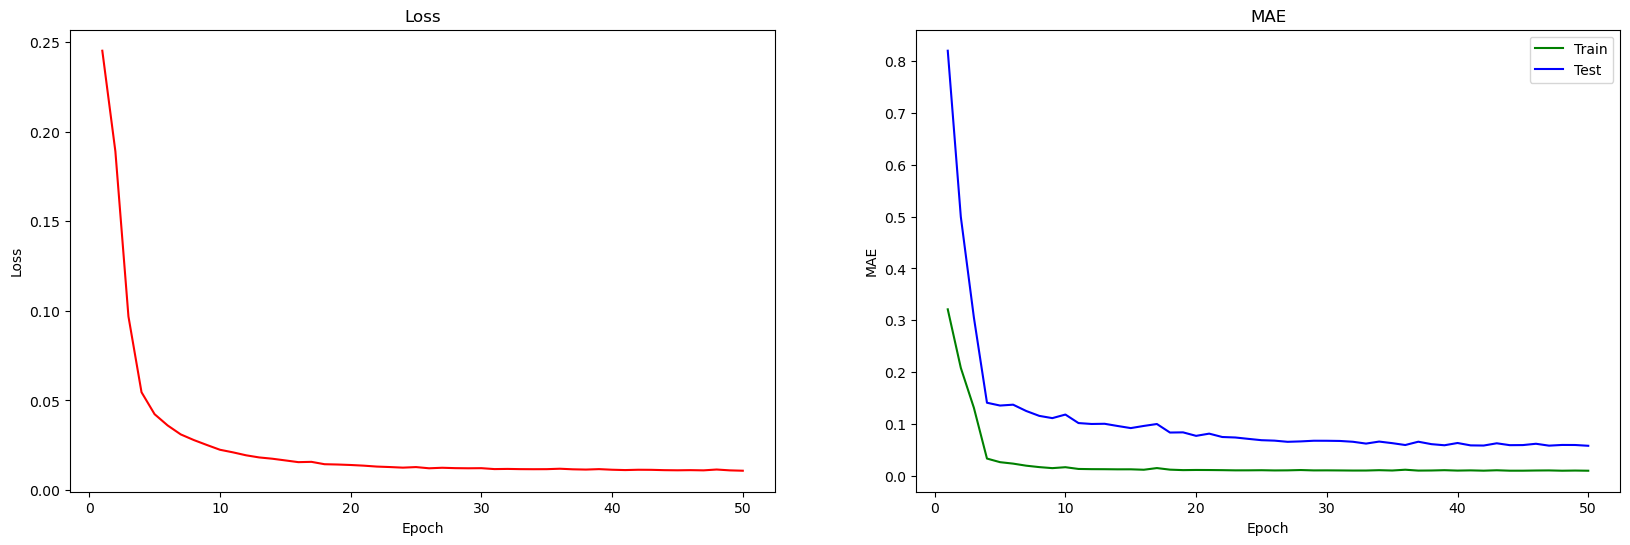

In [7]:
trainset, testset = yahoo_trainset_scaled, yahoo_testset_scaled

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.001
epochs = 50
window_len = 7
input_size = 6
output_size = 1
train_dataset = YahooDatasetSW_singlestep(trainset, window_len, yahoo_class_idx)
test_dataset = YahooDatasetSW_singlestep(testset, window_len, yahoo_class_idx)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = TransformerDecoder(seq_len=window_len, num_layer=1, input_size=input_size, output_size=output_size, d_model=6, num_heads=1, feedforward_dim=32).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
losses = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae_decoder(model, train_dl, device)
    test_mae = eval_mae_decoder(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    avg_loss = 0
    count = 0
    for i, (src, trg) in enumerate(train_dl):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = loss_fun(out, trg)
        avg_loss += loss.cpu().detach().numpy().item()
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()
        count += 1
    avg_loss /= count
    losses.append(avg_loss)
plot_scores(train_maes, test_maes, losses)